# Desafio: Classificação de potabilidade da água

Será que é possível categorizar a qualidade da água como potável ou não potável, ou seja, determinar se a água é apropriada para consumo? Utilizaremos um conjunto de dados disponível no Kaggle que engloba medições relacionadas à potabilidade da água, indicando sua adequação para consumo.

Os dados podem ser acessados através da seguinte URL: https://raw.githubusercontent.com/alura-cursos/classificacao_xgboost/main/Atividades/water_potability.csv

Cada linha do conjunto de dados representa uma amostra de água com features específicas, e a coluna “Potability” indica se a água está adequada para consumo, sendo 0 não potável e 1 potável.

## Desafio 1

Faça uma verificação da base garantindo que os dados estão formatados e não há dados ausentes, e então crie um modelo usando o XGBoost e obtenha as métricas: relatório de classificação, curva ROC AUC e matriz de confusão. 

In [1]:
import pandas as pd

df = pd.read_csv('./water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


As colunas possuem todas dados do tipo numérico, mas é possível observar presença de valores nulos. Como meu interesse aqui é na modelagem, vou simplesmente eliminar as linhas que possuem valor nulo (o ideal seria verificar o impacto disso e, talvez, adotar outra estratégia para tratar os valores nulos).

In [3]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


In [4]:
X = df.drop('Potability', axis=1)
y = df['Potability']

In [5]:
y.value_counts(normalize=True)

0    0.596718
1    0.403282
Name: Potability, dtype: float64

Os dados estão levemente desbalanceados. Não irei fazer nenhum tratamento.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [7]:
from xgboost import XGBClassifier

model = XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

 Não potável       0.68      0.74      0.71       300
     Potável       0.55      0.48      0.51       203

    accuracy                           0.63       503
   macro avg       0.62      0.61      0.61       503
weighted avg       0.63      0.63      0.63       503



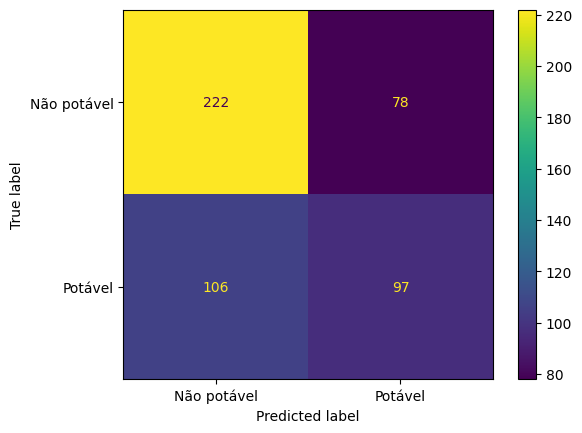

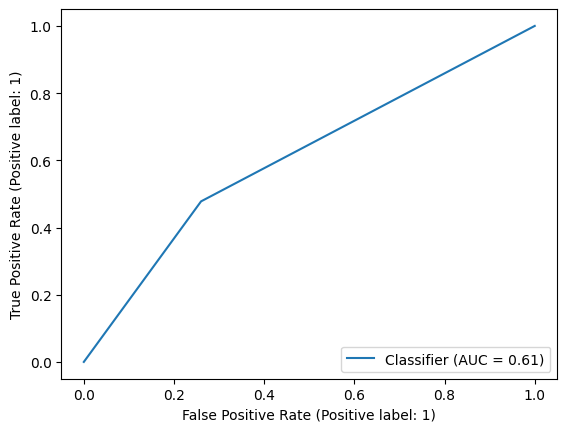

In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay

print(classification_report(y_test, y_pred, target_names=['Não potável', 'Potável']))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Não potável', 'Potável'])
RocCurveDisplay.from_predictions(y_test, y_pred);

O modelo com os valores padrões está apresentando **resultados ruins**, com um recall de 48% na classificação de água potável. A taxa de falsos negativos (52%) está alta, com o **modelo acertando menos da metade**.

## Desafio 2

Agora você vai realizar a validação cruzada! Ah, e não esquece de usar a técnica de Early Stopping para encontrar o número ideal de rodadas do XGBoost.

Como temos uma quantidade razoável de entradas, vou usar somente os dados de treino na validação cruzada.

In [10]:
import xgboost as xgb

dmatrix = xgb.DMatrix(data=X_train, label=y_train)
cv_results = xgb.cv(
    params={'objective': 'binary:logistic'},
    dtrain=dmatrix,
    num_boost_round=100,
    early_stopping_rounds=5,
    nfold=4,
    seed=0,
    metrics='error',
    as_pandas=True
)
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.304598,0.017013,0.371353,0.017794
1,0.273210,0.025725,0.362069,0.017444
2,0.234969,0.018092,0.345491,0.012210
3,0.219717,0.013255,0.344828,0.013910
4,0.196950,0.017297,0.338196,0.022232
5,0.185455,0.013298,0.342175,0.027374
6,0.169761,0.017606,0.340849,0.025888
7,0.154288,0.023179,0.337533,0.023077
8,0.144120,0.015866,0.340849,0.029208
9,0.127321,0.013712,0.333554,0.025537


In [11]:
print(f'Acurácia: {1-cv_results["test-error-mean"].iloc[-1]}')

Acurácia: 0.666445623342175


Verificando a métrica auc:

In [12]:
cv_results = xgb.cv(
    params={'objective': 'binary:logistic'},
    dtrain=dmatrix,
    num_boost_round=100,
    early_stopping_rounds=5,
    nfold=4,
    seed=0,
    metrics='auc',
    as_pandas=True
)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.780867,0.022242,0.637389,0.021932
1,0.825382,0.026907,0.657440,0.033117
2,0.859180,0.022406,0.673667,0.025533
3,0.884824,0.011748,0.678957,0.019580
4,0.904400,0.015903,0.683985,0.026271
5,0.914566,0.013266,0.687812,0.027598


## Desafio 3

Agora você vai aplicar os conhecimentos novos e realizar o ajuste de hiperparâmetros.

Vou utilizar o Grid Search para isso, ajustando os mesmos hiperparâmetros sugeridos no curso, mas usando o recall como métrica para diminuir a taxa de falsos negativos:

In [16]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [0, 2, 4, 6, 10],
    'colsample_bytree': [0.1, 0.5, 1],
    'n_estimators': [10, 25, 50]
}

model_gridsearch = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic'),
    param_grid=params,
    scoring='recall',
    cv=4
)

model_gridsearch.fit(X_train, y_train)

print(f'Melhores hiperparâmetros: {model_gridsearch.best_params_}')
print(f'Melhor recall: {model_gridsearch.best_score_}')

Melhores hiperparâmetros: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50}
Melhor acurácia média: 0.4703947368421053


Validando o modelo com os melhores hiperparâmetros:

              precision    recall  f1-score   support

 Não potável       0.68      0.75      0.71       300
     Potável       0.57      0.48      0.52       203

    accuracy                           0.64       503
   macro avg       0.62      0.62      0.62       503
weighted avg       0.64      0.64      0.64       503



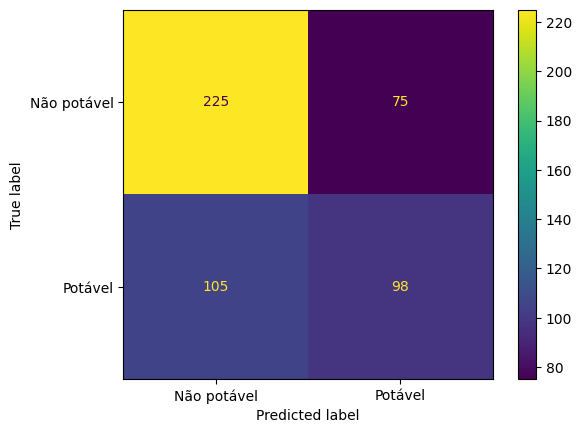

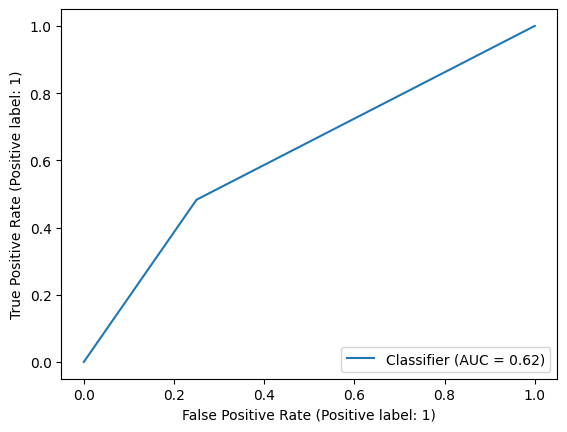

In [17]:
y_pred = model_gridsearch.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Não potável', 'Potável']))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Não potável', 'Potável'])
RocCurveDisplay.from_predictions(y_test, y_pred);

Em comparação com o modelo anterior, é possível observar resultados muito parecidos. A acurácia ficou 0.01 acima. Com relação à classe "Potável", o recall foi o mesmo, com um pequeno aumento de 0.02 na precisão.